In [49]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import mshr

### Solve the original system for full-field solution

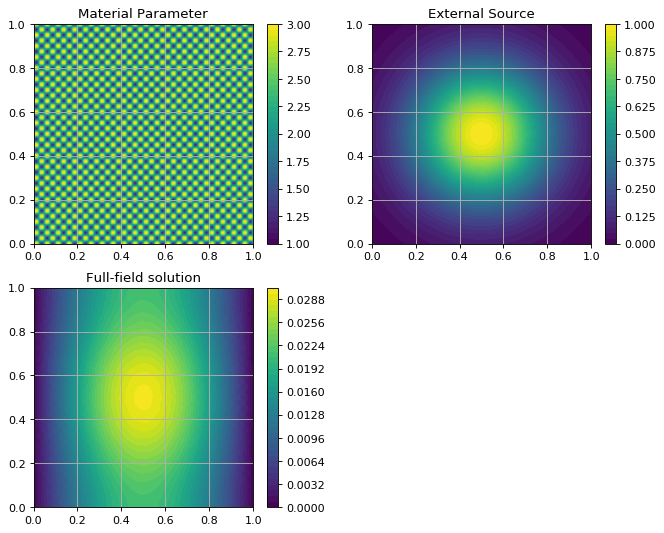

In [159]:
wavelength = np.array([1.0/20, 1.0/20]);
wavenumber = 2*np.pi/wavelength
C = Expression("2.0 + sin(k1*x[0]) * cos(k2*x[1])", k1=wavenumber[0], k2=wavenumber[1], degree=2)
f = Expression("exp(-amplitude*(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2) ))", amplitude = 10, degree = 2)
# create a very fine mesh so that it the finite element solution can capture
# the fluctuation in the material parameter C
mesh = UnitSquareMesh(200, 200)
V = FunctionSpace(mesh, "Lagrange", 2)

u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(v), C * grad(u)) * dx 
L = f * v * dx
# solve PDE for the full-field solution
u_ff = Function(V)
solve(a == L, u_ff, DirichletBC(V, Constant(0.0), (
    lambda x, on_boundary: (near(x[0], 0, DOLFIN_EPS_LARGE) or near(x[0], 1, DOLFIN_EPS_LARGE)) and on_boundary)))


# plot material parameter and solution
plt.figure(figsize=(10,8), dpi=80)
plt.subplot(2,2,1)
plt.colorbar(plot(project(C, V), title="Material Parameter")); plt.grid()

plt.subplot(2,2,2)
plt.colorbar(plot(project(f, V), title="External Source")); plt.grid()

plt.subplot(2,2,3)
plt.colorbar(plot(u_ff, title="Full-field solution")); plt.grid()

### Solve the microscopic BVP to obtain the macroscopic elastic tensor

0.0025000000000000005


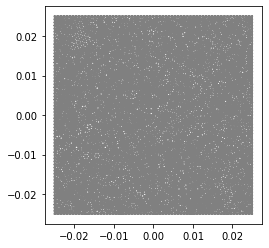

In [161]:
wavelength = np.array([1.0/20, 1.0/20]);
wavenumber = 2*np.pi/wavelength
vertices = np.array([[-wavelength[0]/2, -wavelength[1]/2], 
                     [wavelength[0]/2, -wavelength[1]/2],
                     [wavelength[0]/2, wavelength[1]/2],
                     [-wavelength[0]/2, wavelength[1]/2]])
domain = mshr.Polygon([Point(vertices[0,:]), Point(vertices[1,:]), 
                       Point(vertices[2,:]), Point(vertices[3,:])])
mesh_RVE = mshr.generate_mesh(domain, 48)

# volume of the RVE
vol = np.prod(wavelength)
print(vol)

plot(mesh_RVE)

In [162]:
# class used to define the periodic boundary map
class PeriodicBoundary(SubDomain):
    # Constructor
    def __init__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        super().__init__()
        self.TOL = TOL
        self.vertices = vertices
        # vectors generating periodicity
        self.a = np.zeros((2, 2))
        self.a[0,:] = vertices[1,:] - vertices[0,:]
        self.a[1,:] = vertices[3,:] - vertices[0,:]
        
        # vectors normal to vectors a[0,:] and a[1,:]
        self.n = np.zeros((2,2))
        self.n[0,:] = [ -self.a[0,1], self.a[0,0] ]
        self.n[1,:] = [ -self.a[1,1], self.a[1,0] ]
        
        assert np.dot(self.n[0,:], self.a[0,:]) < self.TOL
        assert np.dot(self.n[1,:], self.a[1,:]) < self.TOL
    
    def inside(self, x, on_boundary):
        # return True if x is on the left or bottom boundaries
        # AND NOT on one of the bottom-right or top-left vertices
        top_left = np.allclose(x, self.vertices[3,:], self.TOL)
        bottom_right = np.allclose(x, self.vertices[1,:], self.TOL)
        x_vector = x - self.vertices[0,:]
        bottom = (np.abs(np.dot(self.n[0,:], x_vector)) < self.TOL)
        left = (np.abs(np.dot(self.n[1,:], x_vector)) < self.TOL)
            
        return (left or bottom) and \
            (not (top_left or bottom_right)) and on_boundary
    # Map right boundary (R) to the left boundary (L)
    def map(self, x, y):
        # top right node
        if np.allclose(x, self.vertices[2,:]):
            y[0] = x[0] - (self.a[0, 0] + self.a[1,0])
            y[1] = x[1] - (self.a[0, 1] + self.a[1,1])
        # right boundary
        elif np.abs(np.dot(self.n[1,:], x - self.vertices[1,:])) < self.TOL:
            y[0] = x[0] - self.a[0,0]
            y[1] = x[1] - self.a[0,1]
        # top boundary
        else:  
            y[0] = x[0] - self.a[1,0]
            y[1] = x[1] - self.a[1,1]

In [163]:
class K(UserExpression):
    def __init__(self, k1, k2, **kargs):
        super().__init__()
        self.k1 = k1
        self.k2 = k2
        
    def eval_cell(self, values, x, cell):
        values[0] = 2 + np.sin(self.k1*x[0]) * np.cos(self.k2*x[1])
        
    def value_shape(self):
        return ()
    
kappa = K(wavenumber[0], wavenumber[1])

In [164]:
kappa = Expression("2.0 + sin(k1*x[0]) * cos(k2*x[1])", 
                   k1=wavenumber[0], k2=wavenumber[1], degree=2)

In [165]:
def epsilon(u):
    return grad(u)

def sigma(u, eps_):
    return kappa * (grad(u) + eps_)

In [166]:
ElemU = FiniteElement("CG", mesh_RVE.ufl_cell(), 1)
ElemL = FiniteElement("R", mesh_RVE.ufl_cell(), 0)
W = FunctionSpace(mesh_RVE, MixedElement([ElemU, ElemL]), 
                 constrained_domain=PeriodicBoundary(vertices))

In [167]:
u, c = TrialFunction(W)   # the fluctuation field
v, d = TestFunction(W)

MacroStrain = Constant(np.array([1.0, 0]))
F = dot(epsilon(v), kappa * (grad(u) + MacroStrain))*dx + c*v*dx + u*d*dx 
a, L = lhs(F), rhs(F)
# a = dot(grad(v), kappa*(grad(u) + Constant(np.array([0, 0])))*dx + c*v*dx + u*d*dx
# L = dot(grad(v), Constant(np.array([1.0, 0])))*dx

w = Function(W)
solve(a == L, w, [])

u_fluc, lagrange_mul = w.split()

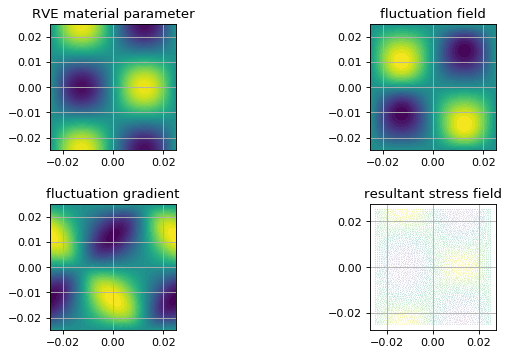

In [177]:
plt.figure(figsize=(8,4.5), dpi=80)
plt.subplot(position=[0.1, 0.9, 0.3, 0.35])
plot(project(kappa, FunctionSpace(mesh_RVE, 'CG', 1)), title="RVE material parameter"); plt.grid(); 
plt.subplot(position=[0.6, 0.9, 0.3, 0.35])
plot(u_fluc, title="fluctuation field"); plt.grid()
plt.subplot(position=[0.1, 0.4, 0.3, 0.35])
plot(u_fluc.dx(0), title="fluctuation gradient"); plt.grid()
plt.subplot(position=[0.6, 0.4, 0.3, 0.35])
plot(sigma(u_fluc, MacroStrain), title="resultant stress field"); plt.grid()

Now, we compute the macroscopic tangent $\overline{\mathbf{C}}$. This tangent is a second-order tensor and its components can be computed by solving only microscopic boundary value problems. In fact, at the macroscopic we know that the resultant constitutive is linear and given by
\begin{equation}
    \overline{\mathbf{q}} = \overline{\mathbf{C}}\cdot \overline{\mathbf{p}}
\end{equation}
Therefore, if we choose $\overline{\mathbf{p}_{i}}$ to be the unit basis vectors in $\mathbb{R}^2$, then we can derive $\overline{\mathbf{q}}_{i}$ as the $i^\text{th}$-column of $\overline{\mathbf{C}}$. Indeed, let us conosider $\overline{\mathbf{p}}_1 = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$. Then, it implies that
\begin{equation}
\overline{q}_i = \sum\limits_{j}\overline{C}_{ij} \overline{p}_j = C_{i\,\times}
\end{equation}

In [169]:
I = np.eye(2)
C_Macro = np.zeros((2, 2))

w = Function(W)
for irun in range(2):
    MacroStrain = Constant(I[:,irun])
       
    F = dot(epsilon(v), sigma(u, MacroStrain))*dx + c*v*dx + u*d*dx 
    a, L = lhs(F), rhs(F)
    
    solve(a == L, w, [])
    u_fluc, lagrange_mul = w.split()
    
    C_Macro[:, irun] = np.array([assemble(sigma(u_fluc, MacroStrain)[i]*dx)\
                     for i in range(2)]) / vol

In [170]:
C_Macro

array([[1.93546648e+00, 1.24506780e-06],
       [1.24506780e-06, 1.93546754e+00]])

### Solve the homogenized boundary value problem

In [173]:
mesh_Macro = UnitSquareMesh(10, 10, "crossed")
V_Macro = FunctionSpace(mesh_Macro, "CG", 1)

bc = DirichletBC(V_Macro, 0, lambda x, on_boundary: (
    near(x[0], 0, DOLFIN_EPS_LARGE) or near(x[0], 1, DOLFIN_EPS_LARGE)) \
    and on_boundary)

u = TrialFunction(V_Macro)
v = TestFunction(V_Macro)
a = dot(grad(v), Constant(C_Macro) * grad(u)) * dx 
L = f * v * dx
# solve PDE
u_homo = Function(V_Macro)
solve(a == L, u_homo, bc)

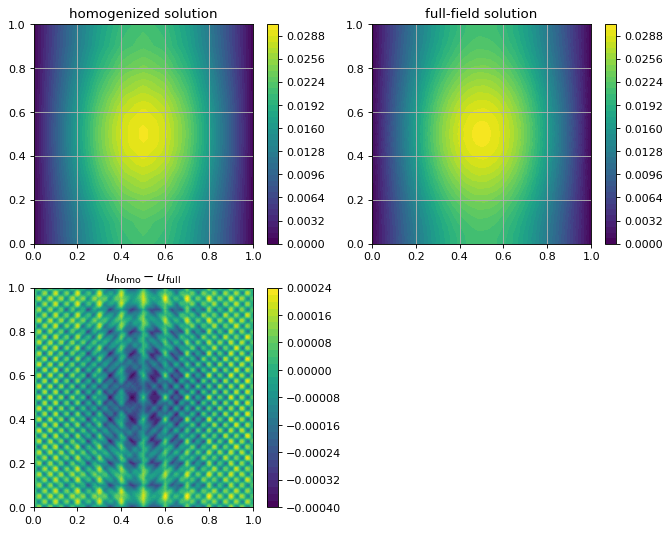

In [174]:
plt.figure(figsize=(10, 8), dpi=80)

plt.subplot(2,2,1)
plt.colorbar(plot(u_homo, title="homogenized solution")); plt.grid()

plt.subplot(2,2,2)
plt.colorbar(plot(u_ff, title="full-field solution")); plt.grid()

plt.subplot(2,2,3)
plt.colorbar(plot(project(u_homo, V) - u_ff,
             title="$u_{\mathrm{homo}} - u_{\mathrm{full}}$"))